# VISUALIZATION:
Which structural brain features were used by the model the most? Which ones were not used at all?

In [1]:
from imagen_post_hoc_helper import *

%matplotlib inline

Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.


In [2]:
DATA_DIR = "/ritter/share/data/IMAGEN"
posthoc = IMAGEN_posthoc()

## Playground: understand SHAP values

Lesson learned: 
<div class="alert alert-block alert-success">
The `SHAP values` sum to either `0.42` or `-0.58` for all subjects. The base-value is `0.58`. Therefore, when added to the base-value it becomes either `1` or `0`. From the above graph we can see that the subjects for whom the SHAP values sum to `0.42` (or `1`) are mostly predicted by the ML model as class 1 or AAM. And the subjects for whom the SHAP values sum to `0.58` (or `0`), are predicted by the model as class 0. <br>
The stochasticity though is un-understood. It could be stemming from the stochasticity in the SHAP estimation techniques.
</div>

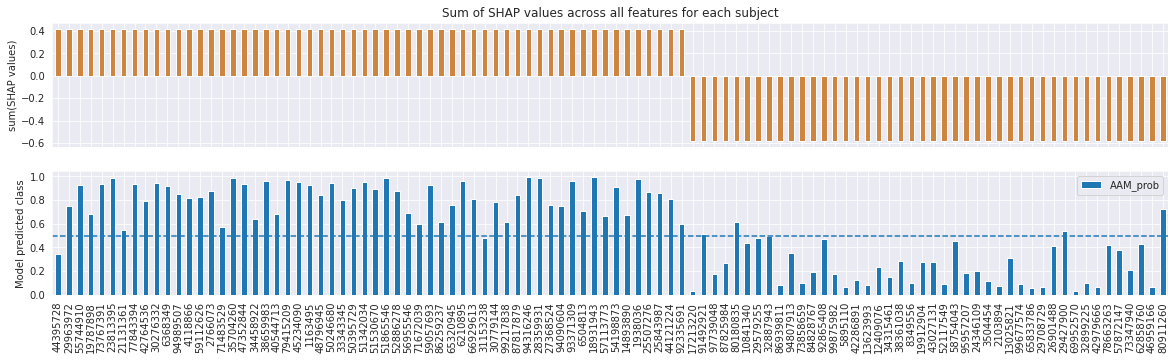

In [3]:
# 1) how does SHAP work? Do the SHAP values consistently sum to 1 or 0 or -1 across all features?
FU3 = "newholdout-clean-fu3-espad-fu3-19a-binge-n102.h5"
X_FU3, X_col_FU3, Other = posthoc.get_holdout_data(FU3)
# load raw SHAP values from run 0
RBF0_FU3 = "/ritter/share/data/IMAGEN/posthoc/explainers/SVM-rbf0_FU3.sav"
with open(RBF0_FU3, 'rb') as fp:
    load_shap_values = pickle.load(fp)
df = pd.DataFrame(load_shap_values.values, columns=X_col_FU3, index=Other[1])
df = df.sum(axis=1).sort_values(ascending=False)

f, axes = plt.subplots(2, 1, sharex=True, figsize=(20, 5))
# sum over all features
ax = df.plot.bar(rot=90, ax=axes[0], grid=True, color='peru',
    xlabel='Subject IDs (holdout)', ylabel=r'sum(SHAP values)',                                                 
    title='Sum of SHAP values across all features for each subject',
    legend=False)

# get the model predictions
df_result = pd.read_csv("/ritter/share/jihoon/imagen_ml/MLpipelines/results/holdout_all-tp-clean_run.csv")
df_result = df_result.loc[(df_result[['tp','technique','model','trial']]==('fu3', 'cb', 'SVM-rbf', 0)).all(axis=1)]

scores = pd.DataFrame()

scores['ID'] = eval(df_result['holdout_ids'].values[0])
scores['AAM_prob'] = (np.array(eval(df_result['holdout_probs'].values[0]))[:,1])#>=0.51).astype(int)
scores = scores.set_index('ID').reindex(df.index)
scores.plot(kind='bar', rot=90, ax=axes[1], ylabel='Model predicted class')
axes[1].axhline(0.5, ls='dashed')
plt.show()


<div class="alert alert-block alert-success">
    1. Are the values normally distributed? **No. Skewed right distribution.** <br>
    2. how do the cumulative sum look? Are there some big players holding most of the SHAP values? **No big players but some do have a higher value**
</div>

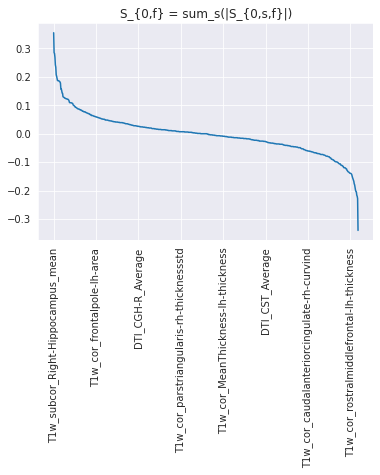

In [4]:
# sum over all subjects per features
df = pd.DataFrame(load_shap_values.values, columns=X_col_FU3, index=Other[1])
df_sf = df.sum(axis=0).sort_values(ascending=False)
df_sf.plot(title='S_{0,f} = sum_s(|S_{0,s,f}|)', rot=90)
plt.show()

In [5]:
# Features with top sum, ignoring the sign of SHAP values ?!
top_features = df_sf[df_sf.abs()>.2].index.to_list()
print(top_features)
get_featuretype_cnt(top_features)

['T1w_subcor_Right-Hippocampus_mean', 'T1w_cor_rostralanteriorcingulate-rh-thickness', 'T1w_subcor_Right-Amygdala_volume', 'T1w_cor_superiorfrontal-rh-thickness', 'T1w_subcor_Right-Caudate_mean', 'T1w_cor_inferiorparietal-rh-thicknessstd', 'T1w_cor_rostralanteriorcingulate-rh-volume', 'T1w_subcor_Optic-Chiasm_volume', 'DTI_PLIC-R_Average', 'T1w_cor_parahippocampal-rh-area', 'T1w_cor_parstriangularis-rh-area', 'T1w_cor_parahippocampal-lh-thicknessstd', 'T1w_cor_cuneus-rh-thickness', 'T1w_subcor_Left-Pallidum_mean']


,Total,DTI,T1w,subcor,subcor_area,subcor_vol,cor,cor_area,cor_curv,cor_vol,cor_thick,cor_foldind
0,14,1,13,5,3,2,8,2,0,1,5,0


### Show mean|SHAP| of all features

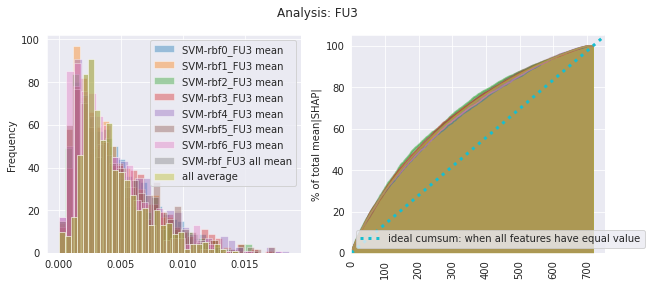

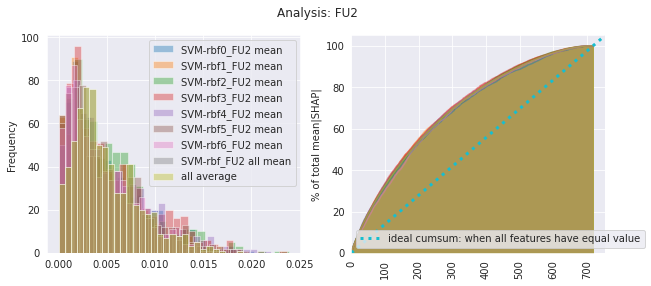

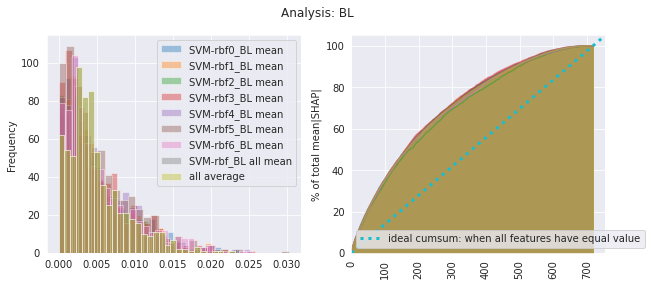

In [6]:
for tp in ['FU3', 'FU2', 'BL']:
    df = posthoc.read_SHAP(f'all_{tp}_SHAP.csv').filter(regex="SVM-rbf.* mean")
    df["all average"] =  df.apply(np.mean, axis=1)
    df = df.sort_values("all average", ascending=False, ignore_index=True)
    
    f, axes = plt.subplots(1,2, figsize=(10,4))
    plt.suptitle(f'Analysis: {tp}')
    # are the values normally distributed?
    for c in df:
        df[c].plot.hist(bins=30, alpha=0.4, legend=True, ax=axes[0])

    # how do the cumulative sum look? Are there some big players holding most of the SHAP values?
    # to determine the threshold
    # calculate the percentage for the y-axis
    cumsum = df.cumsum().apply(lambda x: 100*x/x.max())
    ax = cumsum.plot.area(stacked=False, rot=90, legend=False, ax=axes[1], grid=True, ylabel='% of total mean|SHAP|')
    ax.set_xlim([0, ax.get_xlim()[-1]])
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls='dotted', lw=3, label='ideal cumsum: when all features have equal value')

    handles, labels = ax.get_legend_handles_labels()
    ax.legend([handles[0]], [labels[0]])
    plt.show()

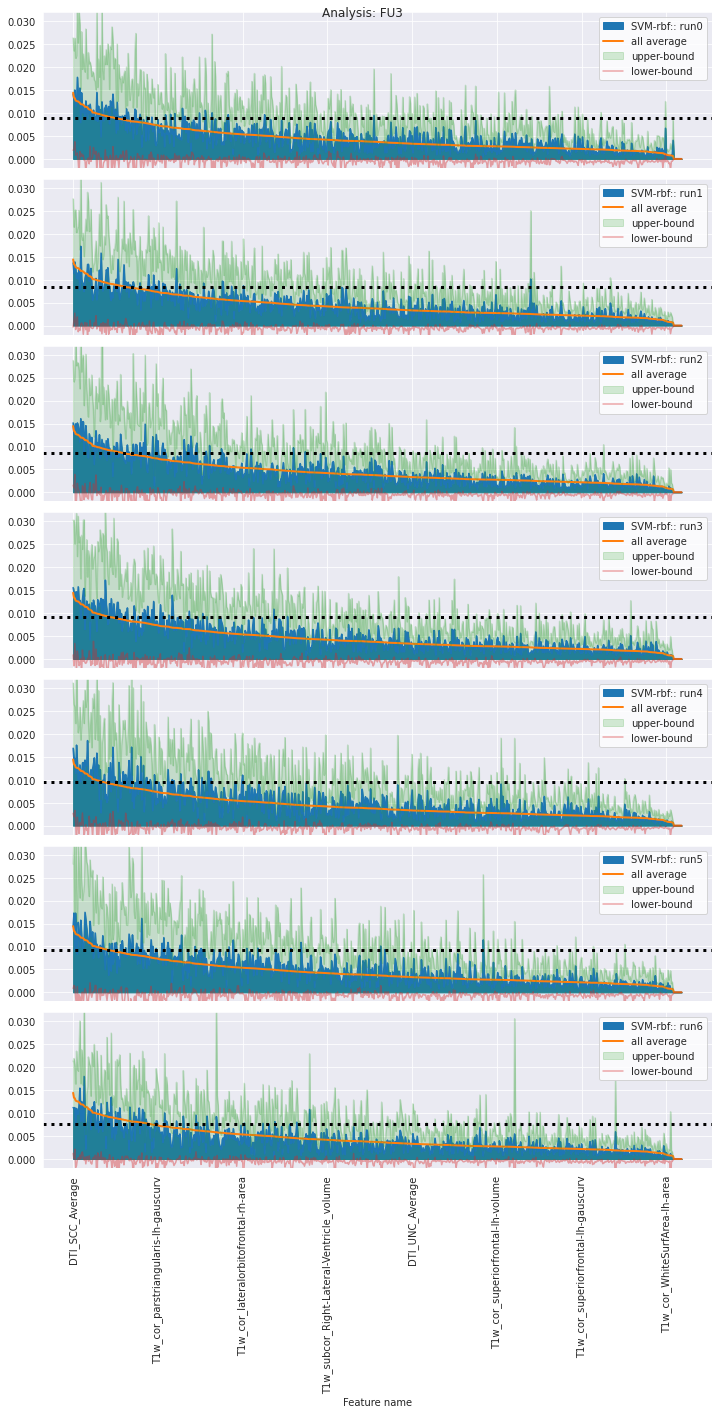

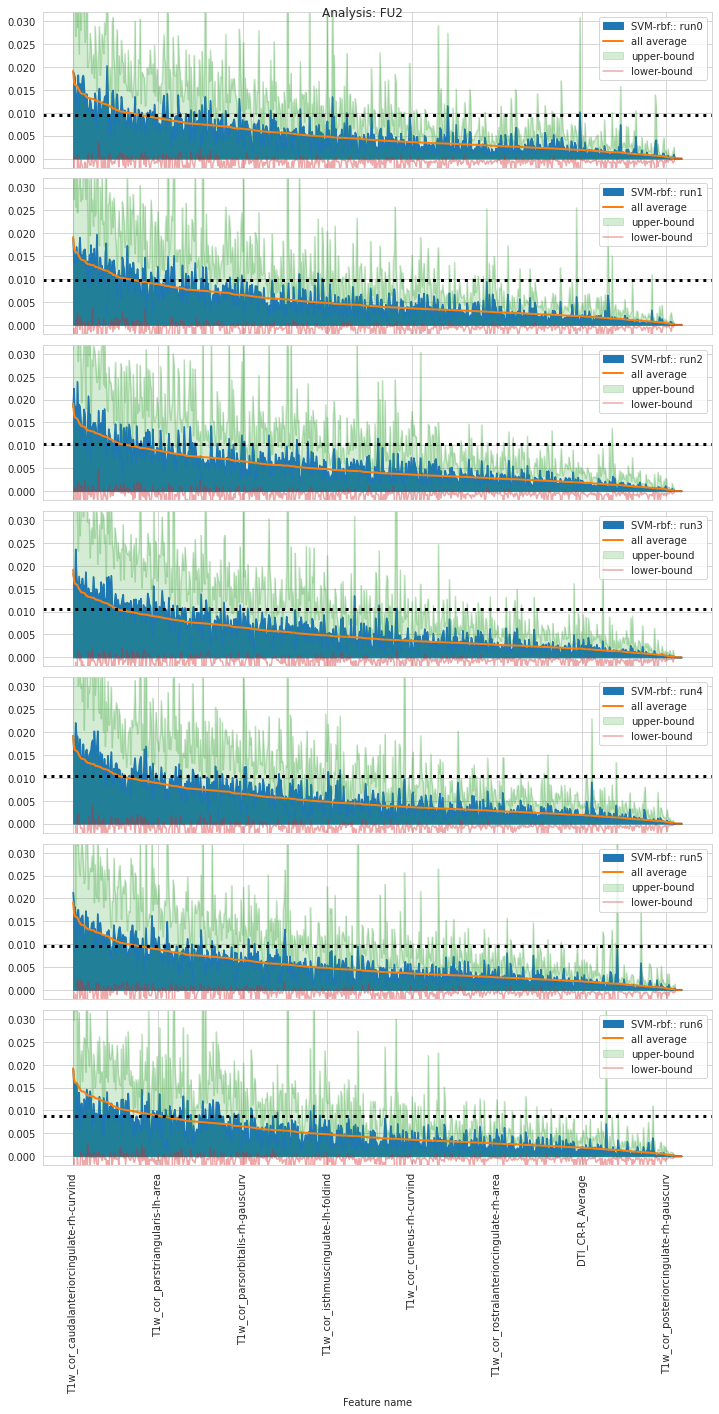

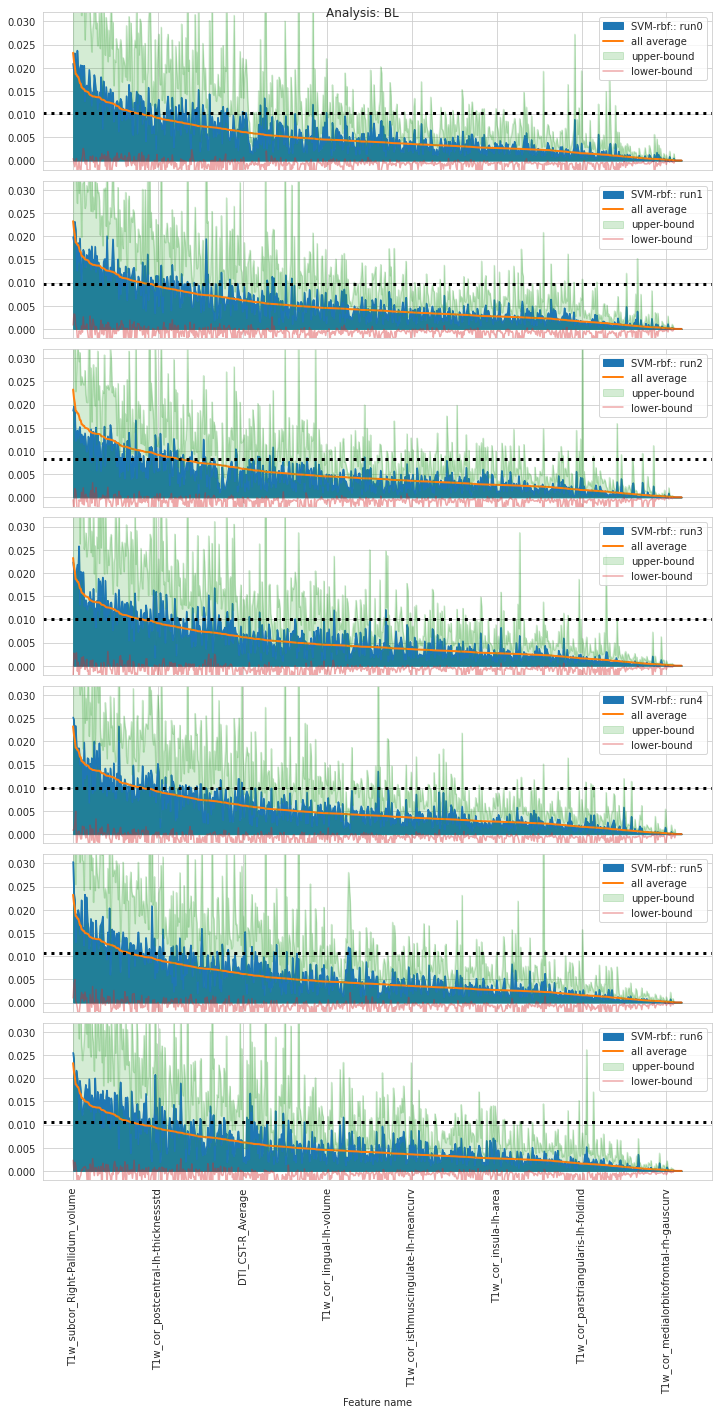

In [7]:
for tp in ['FU3', 'FU2', 'BL']:
    f, axes = plt.subplots(7,1, figsize=(10,20), sharex=True, sharey=True)
    sns.set_style('whitegrid')
    plt.suptitle(f'Analysis: {tp}')

    for i, axis in enumerate(axes.ravel()):
        df = posthoc.read_SHAP(f'all_{tp}_SHAP.csv').set_index('Feature name').filter(regex="SVM-rbf.*")
        df["all average"] =  df.filter(regex="SVM-rbf.* mean").apply(np.mean, axis=1)
        df = df.sort_values("all average", ascending=False)
        df.plot(y=f'SVM-rbf{i}_{tp} mean', label=f'SVM-rbf:: run{i}',  kind='area', 
                       rot=90, ax=axis, legend=True)
        df["all average"].plot(lw=2, label="all average", rot=90, ax=axis, legend=True)  

        axis.set_ylim([-0.002,0.032])

        # plot the upper and lower standard deviations in SHAP
        df[f'SVM-rbf{i}_{tp} std_up'] = df[f'SVM-rbf{i}_{tp} mean']  + df[f'SVM-rbf{i}_{tp} std'] 
        df[f'SVM-rbf{i}_{tp} std_down'] = df[f'SVM-rbf{i}_{tp} mean']  - df[f'SVM-rbf{i}_{tp} std']

        df.plot(y=f'SVM-rbf{i}_{tp} std_up', kind='area', label='upper-bound', rot=90, ax=axis, legend=True,  alpha=0.2, stacked=False)
        df.plot(y=f'SVM-rbf{i}_{tp} std_down', kind='line', label='lower-bound', rot=90, ax=axis, legend=True, alpha=0.4, stacked=False)

        axis.axhline(2*df[f'SVM-rbf{i}_{tp} mean'].mean(), ls='dotted',lw=3, color='k')
    #     df_sorted[f'SVM-rbf{i}_{tp} mean'].cumsum().plot.area(alpha=0.2, rot=90, ax=axis)
    # SHAP_SVMrbf.filter(regex='SVM-rbf.* std').sort_values(
    #     by='SVM-rbf_{tp} all std', ascending=False).drop(columns=['SVM-rbf_{tp} all std']).plot(
    # alpha=0.5, rot=90, ax=axes[1])
    # SHAP_SVMrbf['SVM-rbf_{tp} all std'].sort_values(ascending=False).plot(lw=2, rot=90, ax=axes[1])
    plt.tight_layout()
    plt.show()

## Show the informative features: FU3, FU2, BL

In [8]:
top_features_all = {}
for tp in ['FU3', 'FU2', 'BL']:
    print(f'------------------------------------\n    Analysis: {tp}   \n------------------------------------')

    df = posthoc.read_SHAP(f'all_{tp}_SHAP.csv').set_index('Feature name').filter(regex="SVM-rbf.* mean")
    df["all average"] =  df.filter(regex="SVM-rbf.* mean").apply(np.mean, axis=1)
    df = df.sort_values("all average", ascending=False)   
    # set the threshold as 2 times the average mean|SHAP| 
    thresh = 1.9 * df['all average'].mean()

#     display(df.head(20).style.background_gradient(vmin=thresh, cmap='PuBu_r').highlight_between(right=thresh, color='black'))
    
    # top features are those which beat the threshold ####in at least 6 out of the 7
    top_features = df[df.filter(regex="SVM-rbf.* mean").apply(lambda x: x>=thresh).all(axis=1)]#.sum(axis=1) >= len(df.filter(regex="SVM-rbf.* mean").columns)-1]
    top_features = top_features.index.to_list()
    display(top_features)
    display(get_featuretype_cnt(top_features))
    top_features_all.update({tp:top_features})

------------------------------------
    Analysis: FU3   
------------------------------------


['DTI_SCC_Average',
 'T1w_cor_lateraloccipital-rh-thickness',
 'T1w_subcor_CSF_mean',
 'T1w_subcor_Brain-Stem_mean',
 'T1w_subcor_Right-Amygdala_volume',
 'T1w_cor_parahippocampal-rh-area',
 'T1w_cor_cuneus-rh-thickness',
 'T1w_subcor_Left-Hippocampus_mean',
 'T1w_subcor_Left-choroid-plexus_volume',
 'DTI_RLIC-R_Average',
 'DTI_RLIC_Average']

,Total,DTI,T1w,subcor,subcor_area,subcor_vol,cor,cor_area,cor_curv,cor_vol,cor_thick,cor_foldind
0,11,3,8,5,3,2,3,1,0,0,2,0


------------------------------------
    Analysis: FU2   
------------------------------------


['T1w_cor_caudalanteriorcingulate-rh-curvind',
 'T1w_cor_caudalanteriorcingulate-lh-thicknessstd',
 'T1w_cor_cuneus-lh-curvind',
 'T1w_cor_pericalcarine-lh-curvind',
 'T1w_subcor_CC_Anterior_mean',
 'T1w_cor_cuneus-rh-thickness',
 'DTI_CST-L_Average',
 'T1w_subcor_WM-hypointensities_mean',
 'T1w_cor_frontalpole-lh-curvind',
 'T1w_subcor_Left-Cerebellum-Cortex_mean',
 'T1w_cor_precentral-rh-gauscurv',
 'T1w_cor_rostralanteriorcingulate-lh-thickness',
 'T1w_subcor_Brain-Stem_mean',
 'T1w_cor_fusiform-lh-thicknessstd',
 'T1w_cor_inferiortemporal-lh-thicknessstd',
 'T1w_subcor_Right-Accumbens-area_mean',
 'DTI_RLIC-R_Average',
 'T1w_subcor_Left-Inf-Lat-Vent_volume']

,Total,DTI,T1w,subcor,subcor_area,subcor_vol,cor,cor_area,cor_curv,cor_vol,cor_thick,cor_foldind
0,18,2,16,6,5,1,10,0,5,0,5,0


------------------------------------
    Analysis: BL   
------------------------------------


['T1w_subcor_Right-Pallidum_volume',
 'T1w_cor_temporalpole-lh-volume',
 'T1w_subcor_Right-Cerebellum-Cortex_volume',
 'T1w_subcor_CC_Anterior_mean',
 'T1w_cor_rostralmiddlefrontal-lh-thicknessstd',
 'T1w_cor_parahippocampal-rh-area',
 'T1w_cor_inferiorparietal-rh-volume',
 'T1w_cor_lateraloccipital-lh-thickness',
 'T1w_cor_bankssts-rh-meancurv',
 'T1w_cor_parahippocampal-rh-volume',
 'T1w_cor_pericalcarine-lh-thickness',
 'DTI_PCR_Average',
 'T1w_cor_superiorparietal-rh-thicknessstd',
 'DTI_PCR-R_Average',
 'T1w_cor_paracentral-lh-area',
 'T1w_cor_parsorbitalis-lh-area',
 'T1w_cor_superiorparietal-lh-thicknessstd',
 'T1w_cor_cuneus-rh-volume',
 'T1w_cor_pericalcarine-rh-thickness',
 'T1w_cor_cuneus-rh-thickness',
 'T1w_subcor_CC_Anterior_volume',
 'T1w_cor_medialorbitofrontal-lh-thicknessstd',
 'DTI_ALIC-R_Average',
 'T1w_cor_isthmuscingulate-rh-thicknessstd',
 'T1w_cor_postcentral-rh-thickness',
 'T1w_subcor_Brain-Stem_mean',
 'DTI_SCC_Average',
 'T1w_cor_medialorbitofrontal-lh-area'

,Total,DTI,T1w,subcor,subcor_area,subcor_vol,cor,cor_area,cor_curv,cor_vol,cor_thick,cor_foldind
0,32,4,28,6,2,4,22,4,3,5,10,0


## Visualize the SHAP values of the top features

### Plot the beeswarm and barplots for the top features

In [9]:
H5 = {'BL': "newholdout-clean-bl-espad-fu3-19a-binge-n102.h5",
    'FU2': "newholdout-clean-fu2-espad-fu3-19a-binge-n102.h5",
    'FU3': "newholdout-clean-fu3-espad-fu3-19a-binge-n102.h5"}

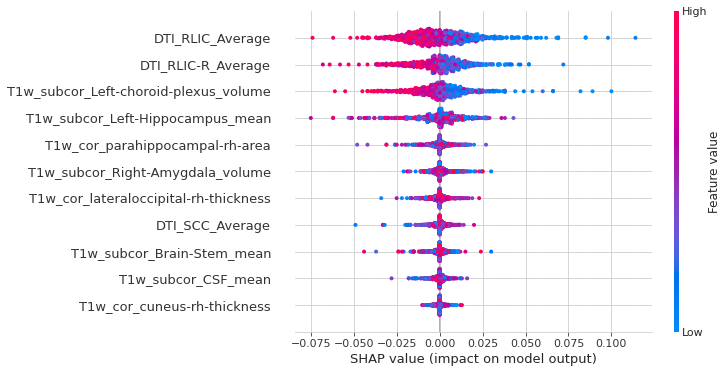

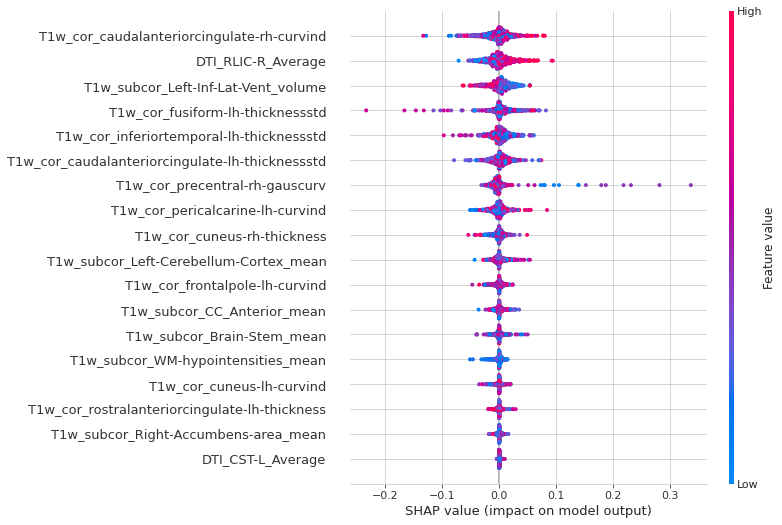

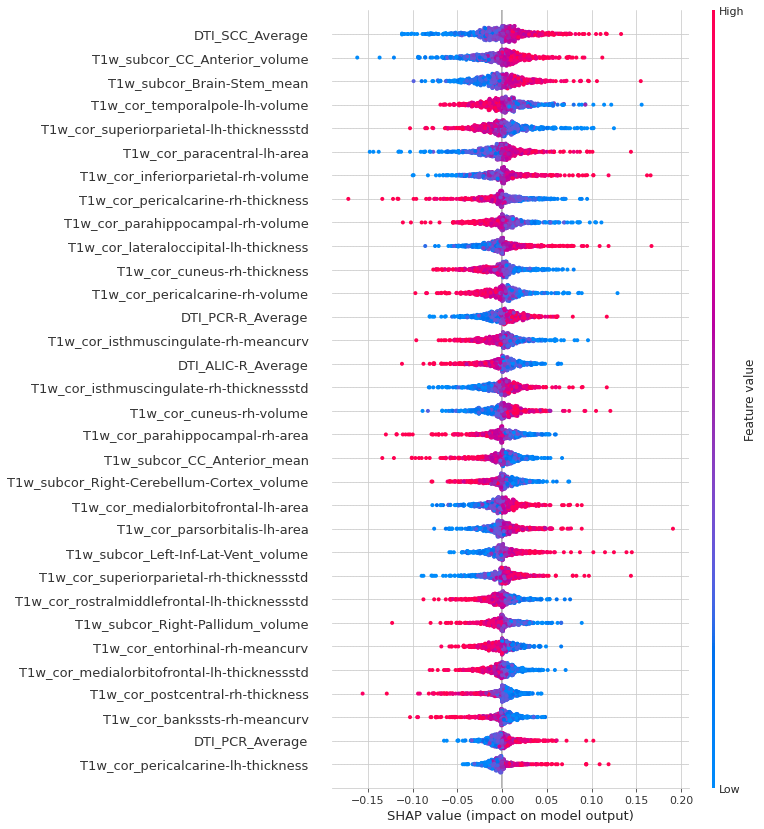

In [10]:
SHAP = RBF0_FU3

for tp in top_features_all:
    feature_names = top_features_all[tp]
    
    # get the feature values from the hdf5 input hdf5 file
    with h5.File('/ritter/share/data/IMAGEN/h5files/'+H5['BL'], "r") as f:
        feature_vals = f['X']
        all_feature_names = [name[:-1] if (')'==name[-1]) else name for name in f.attrs['X_col_names']]
        
        feature_idx = np.where(np.isin(all_feature_names, feature_names))[0]
        feature_vals = feature_vals[:, feature_idx]
        # repeat it 7 times just to be compatible with 7 runs of shap values in summary_plot()
        feature_vals = np.tile(feature_vals,(7,1))
#     display(feature_vals.shape)

    # get SHAP values
    shap_values = None
    for i in range(7): 
        # concatenate results from 7 runs as separate subjects
        with open(f"/ritter/share/data/IMAGEN/posthoc/explainers/SVM-rbf{i}_{tp}.sav", 'rb') as fp:
            vals = pickle.load(fp).values[:,feature_idx]
            if shap_values is None:
                shap_values = vals
            else:
                shap_values = np.vstack((shap_values, vals))

#     display(shap_values.shape)
    shap.summary_plot(shap_values, features=feature_vals, feature_names=feature_names, 
                      max_display=len(feature_names))

 Get the plot

<b> Load the dataset </b>

In [11]:
BL = "newholdout-clean-bl-espad-fu3-19a-binge-n102.h5"
FU2 = "newholdout-clean-fu2-espad-fu3-19a-binge-n102.h5"
FU3 = "newholdout-clean-fu3-espad-fu3-19a-binge-n102.h5"

RBF0_FU3 = "/ritter/share/data/IMAGEN/posthoc/explainers/SVM-rbf0_FU3.sav"
RBF1_FU3 = "/ritter/share/data/IMAGEN/posthoc/explainers/SVM-rbf1_FU3.sav"
RBF2_FU3 = "/ritter/share/data/IMAGEN/posthoc/explainers/SVM-rbf2_FU3.sav"
RBF3_FU3 = "/ritter/share/data/IMAGEN/posthoc/explainers/SVM-rbf3_FU3.sav"
RBF4_FU3 = "/ritter/share/data/IMAGEN/posthoc/explainers/SVM-rbf4_FU3.sav"
RBF5_FU3 = "/ritter/share/data/IMAGEN/posthoc/explainers/SVM-rbf5_FU3.sav"
RBF6_FU3 = "/ritter/share/data/IMAGEN/posthoc/explainers/SVM-rbf6_FU3.sav"

RBF0_FU2 = "/ritter/share/data/IMAGEN/posthoc/explainers/SVM-rbf0_FU2.sav"
RBF0_BL = "/ritter/share/data/IMAGEN/posthoc/explainers/SVM-rbf0_BL.sav"

<b> ROI 01: summary bar plot of feature importnace </b>

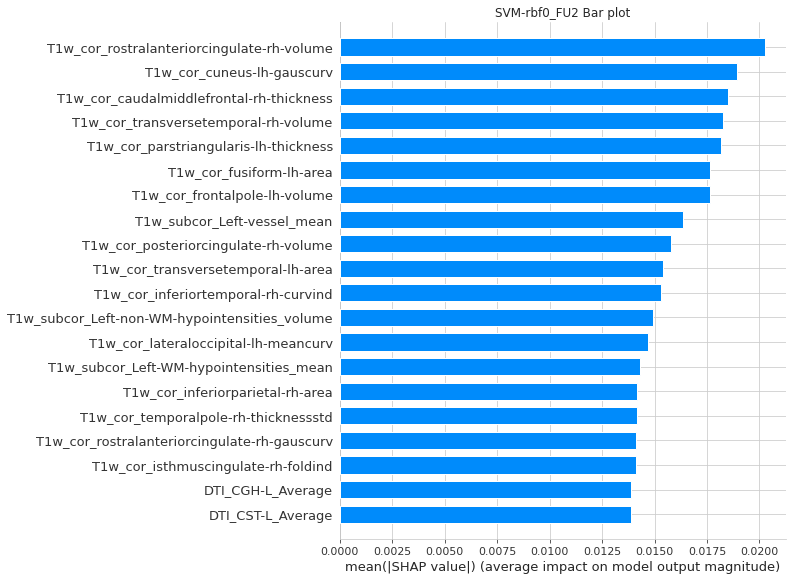

In [12]:
# Plot type: 'Bar', 'Swarm', 'Sex', and 'Class'
SHAP_plot(FU3, RBF0_FU2, 'Bar')#, fig=True)

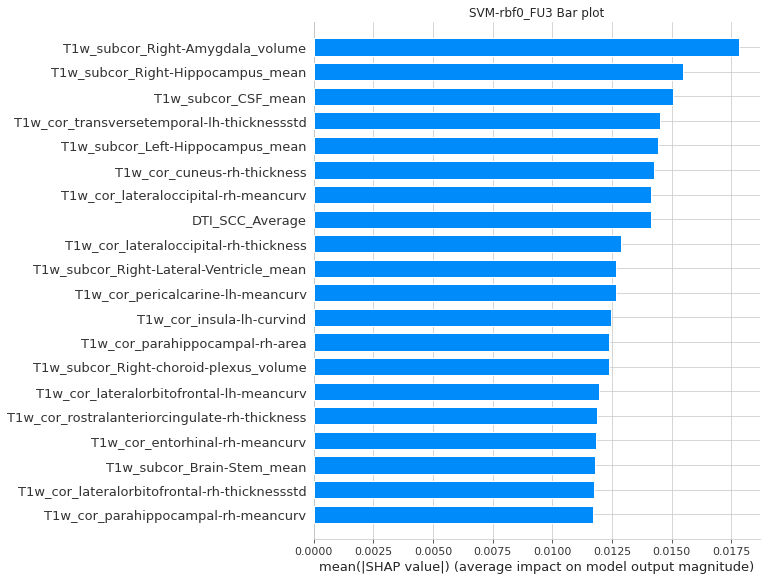

In [13]:
# Plot type: 'Bar', 'Swarm', 'Sex', and 'Class'
SHAP_plot(FU3, RBF0_FU3, 'Bar')#, fig=True)

<b> ROI 02: swarm plot showing shap values vs feature values ordered by feature importance </b>

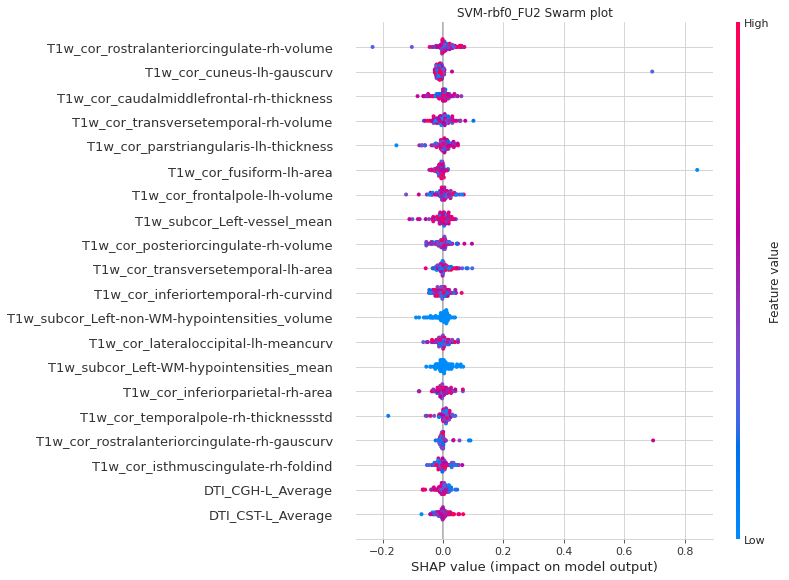

In [14]:
SHAP_plot(FU3, RBF0_FU2, 'Swarm')#, fig=True)

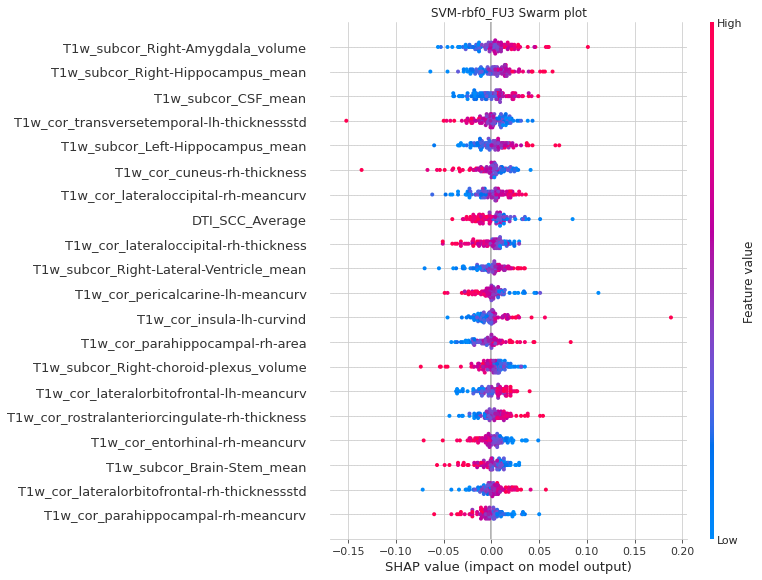

In [15]:
SHAP_plot(FU3, RBF0_FU3, 'Swarm')#, fig=True)

<b> ROI 03: Class difference plot showing shap values vs feature values ordered by feature importance </b>

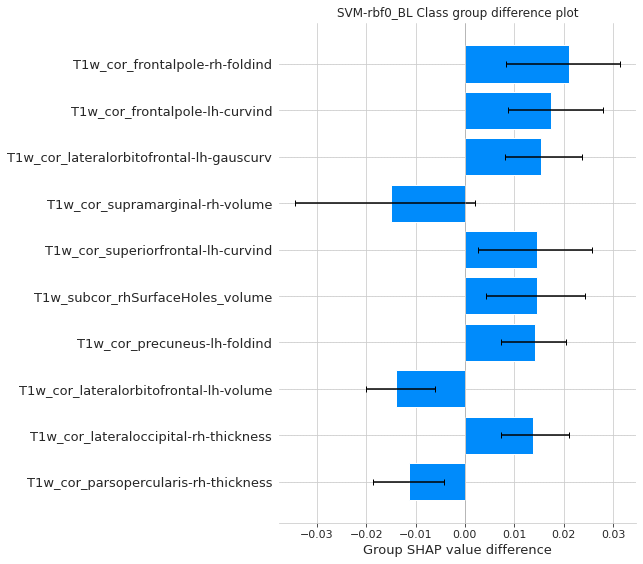

In [16]:
SHAP_plot(FU3, RBF0_BL, 'Class')#, fig=True)

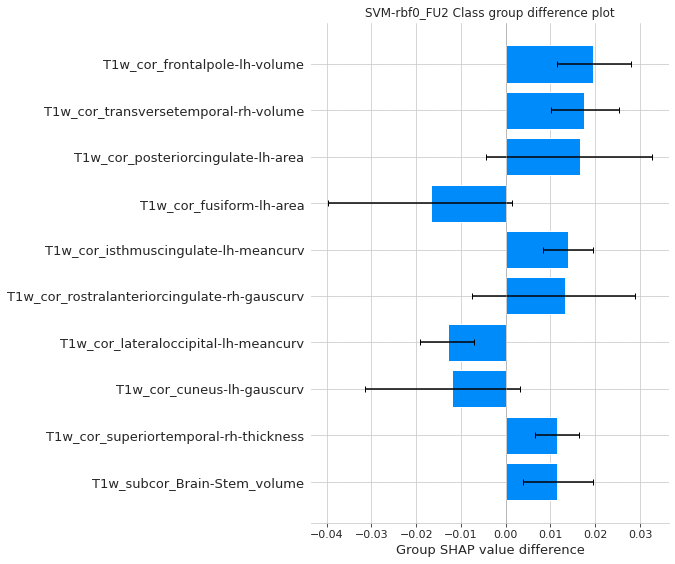

In [17]:
SHAP_plot(FU3, RBF0_FU2, 'Class')#, fig=True)

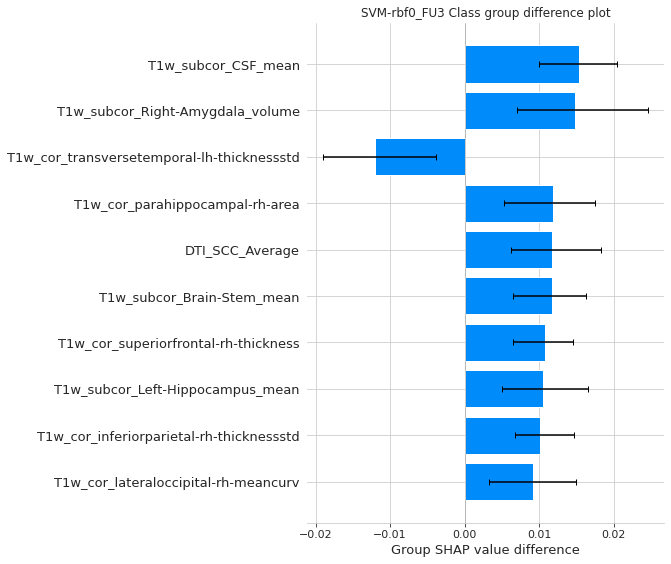

In [18]:
SHAP_plot(FU3, RBF0_FU3, 'Class')#, fig=True)

<b> ROI 04: Sex difference plot showing shap values vs feature values ordered by feature importance </b>

In [19]:
# SHAP_plot(FU3, RBF0_FU3, 'Sex')#, fig=True)

### Feature importance, mean|SHAP| distribution

<b>generate the columns</b>

In [20]:
import seaborn as sns; sns.set_theme(color_codes=True)

In [21]:
SHAP = posthoc.read_SHAP('all_FU3_SHAP.csv')

In [22]:
plt.rcParams["figure.figsize"] = (100,25)

<b> All model: Model by Model

In [23]:
SHAP_T = SHAP.transpose()
SHAP_T = SHAP_T.rename(columns=SHAP_T.iloc[0])

In [ ]:
SHAP_Model = SHAP_T.iloc[5:33]
SHAP_T = SHAP_Model.astype('float')
ax = sns.heatmap(SHAP_T)
plt.title('Heatmap of Feature importance', fontsize=40)
# plt.savefig('/figrues/Heatmap_SHAP_Model.pdf')

Text(0.5, 1.0, 'Heatmap of Feature importance')

In [ ]:
SHAP = SHAP.sort_values(by=['Type','Lobe Region','SVM-rbf_FU3 all mean'],
                         ascending=[True,True,False])
SHAP_T = SHAP.transpose()
SHAP_T = SHAP_T.rename(columns=SHAP_T.iloc[0])

<b> SVM-rbf model </b>

In [ ]:
SHAP_Region = SHAP_T.iloc[26:33]
SHAP_R = SHAP_Region.astype('float')
ax = sns.heatmap(SHAP_R)
plt.title('Heatmap of Feature importance', fontsize=40)
# plt.savefig('figures/Heatmap_SHAP_Model.pdf')

### Feature importance in SVM-rbf, mean of mean|SHAP| distribution

<b> Sorted by value specific

In [ ]:
SHAP2 = SHAP.sort_values(by=['Type','Value','Lobe Region','SVM-rbf_FU3 all mean'],
                         ascending=[True,True,True,False])
SHAP2 = SHAP2.set_index('Feature name')

In [ ]:
SHAP2.columns

In [ ]:
col = list(SHAP2.columns[46:49])+list(SHAP2.columns[4:25])
SHAP2 = SHAP2[col]
SHAP_T = SHAP2.transpose()
ax = sns.heatmap(SHAP_T)

plt.title('Mean of mean|SHAP value| Heatmap on SVM-rbf', fontsize=40)
# plt.savefig('figures/Heatmap_SHAP_value_SVM_rbf.pdf')
plt.show()

In [ ]:
# plt.pcolor(SHAP_T)
# plt.title('Heatmap of Feature importance', fontsize=20)
# plt.colorbar()

<b> Sorted by region specific </b>

In [ ]:
plt.rcParams["figure.figsize"] = (160,40)

In [ ]:
SHAP2 = SHAP.sort_values(by=['Type','Lobe Region','SVM-rbf_FU3 all mean'],
                         ascending=[True,True,False])

In [ ]:
SHAP2 = SHAP2.set_index('Feature name')
col = list(SHAP2.columns[46:49])+list(SHAP2.columns[4:25])
SHAP2 = SHAP2[col]
SHAP_T = SHAP2.transpose()
ax = sns.heatmap(SHAP_T)
plt.title('Mean of mean|SHAP value| Heatmap on SVM-rbf', fontsize=40)
# plt.savefig('figures/Heatmap_SHAP_region_SVM_rbf.pdf')

In [ ]:
# SHAP_T.style.background_gradient(cmap='Blues')

In [ ]:
SHAP_SVM_rbf_T = SHAP_T.iloc[0:3]
SHAP_SVM_rbf_T = SHAP_SVM_rbf_T.astype('float')

In [ ]:
ax = sns.heatmap(SHAP_SVM_rbf_T)
plt.title('Heatmap of mean|SHAP value| on SVM-rbf', fontsize=50)
# plt.savefig('figures/Heatmap_SHAP_SVM_rbf.pdf')

## Show SHAP in Brain

In [ ]:
def get_top_features(tp_list=['FU3', 'FU2', 'BL'], threshold=None, group='POS', viz=False):
    """ generate the dictionary of the mean SHAP of top features """
    ### helper funcs
    def get_featuretype_cnt(fs):
        dfc = pd.DataFrame()
        dfc.loc[0, 'Total'] = len(fs)
        dfc.loc[0, 'DTI'] = len([f for f in fs if 'DTI'==f.split('_')[0]])
        dfc.loc[0, 'T1w'] = len([f for f in fs if 'T1w'==f.split('_')[0]])
        dfc.loc[0, 'subcor'] = len([f for f in fs if 'subcor'==f.split('_')[1]])
        dfc.loc[0, 'subcor_area'] = len([f for f in fs if 'subcor'==f.split('_')[1] and 'mean'==f.split('_')[-1]])
        dfc.loc[0, 'subcor_vol'] = len([f for f in fs if 'subcor'==f.split('_')[1] and 'volume'==f.split('_')[-1]])
        dfc.loc[0, 'cor'] = len([f for f in fs if 'cor'==f.split('_')[1]])
        dfc.loc[0, 'cor_area'] = len([f for f in fs if 'cor'==f.split('_')[1] and 'area'==f.split('-')[-1]])
        dfc.loc[0, 'cor_curv'] = len([f for f in fs if 'cor'==f.split('_')[1] and 'curv' in f.split('-')[-1]])
        dfc.loc[0, 'cor_vol'] = len([f for f in fs if 'cor'==f.split('_')[1] and 'vol' in f.split('-')[-1]])
        dfc.loc[0, 'cor_thick'] = len([f for f in fs if 'cor'==f.split('_')[1] and 'thickness' in f.split('-')[-1]])
        dfc.loc[0, 'cor_foldind'] = len([f for f in fs if 'cor'==f.split('_')[1] and 'foldind' == f.split('-')[-1]])
        dfc = dfc.astype(int)
        return dfc.style.background_gradient(cmap='gray', vmin=0, vmax=len(top_features))

    top_features_dict = {}
    shap_values_dict = {}
    for tp in tp_list:
        # load the mean|SHAP| value
        df = posthoc.read_SHAP(f'all_{tp}_SHAP.csv').set_index('Feature name').filter(regex="SVM-rbf.*")
        columns = df.columns.to_list()
        top = df[columns[:7]]
        top['all average'] = df[columns[-2]]
        std = df[columns[-1]].mean()
        df = top.sort_values("all average", ascending=False)
        
        # Threshold
        if threshold==0:
            for c in top:
                top[c] = np.log1p(df[c].apply(lambda x: x*1000))/1000
            top['new average'] = top.mean(axis=1)
            top['new std'] = top.std(axis=1)
            new_thresh = top['new average'].mean()+2.58*top['new std'].mean()
            thresh = (math.exp(1000*new_thresh)-1)/1000
        elif threshold==1.96:
            # set the threshold as mean|SHAP| + (1.96 * std)
            thresh = df['all average'].mean() + (1.96 * std) # 95%
        elif threshold==2.58:
            # set the threshold as mean|SHAP| + (2.58 * std)
            thresh = df['all average'].mean() + (2.58 * std) # 99%
        elif threshold==3.3:
            # set the threshold as mean|SHAP| + (3.3 * std)
            thresh = df['all average'].mean() + (3.3 * std)  # 99.9%
        else:
            # set the threshold as 2 times the average mean|SHAP|
            thresh = 2 * df['all average'].mean()
#             thresh = 1.9 * df['all average'].mean()
        
        # Top features
        top_features = df[df.filter(regex="SVM-rbf.* mean").apply(lambda x: x>=thresh).all(axis=1)]#.sum(axis=1) >= len(df.filter(regex="SVM-rbf.* mean").columns)-1]
        top_features = top_features.index.to_list()
        top_features_dict.update({tp:top_features})
        
        # load the mean of the SHAP value
        df2 = posthoc.read_SHAP(f'all_SVM-rbf_{tp}_{group}.csv')
        SHAP_mean = df2[top_features]
        col_name = SHAP_mean.columns.to_list()
        SHAP_val = SHAP_mean.mean().to_list()
        SHAP = [i for i in zip(col_name, SHAP_val)]
        shap_values_dict.update({tp: SHAP})

        if viz == True:
            print(f'{"-"*36}\n    Analysis: {tp}   \n{"-"*36} \nThreshold >= {thresh} \n')
            if threshold==0:
                print(f'original: {new_thresh}')
#             display(top_features)
#             print('\n')
            display(SHAP_mean.mean())
            display(get_featuretype_cnt(top_features))
            display(df.head(22).style.background_gradient(vmin=thresh, cmap='PuBu_r').highlight_between(right=thresh, color='black'))
    return top_features_dict, shap_values_dict

### load the top features and mean of Feature values :

#### above SHAP value > 0

In [ ]:
# top_features , All_dm_pos_SHAP = get_top_features(tp_list=['FU3', 'FU2', 'BL'], threshold=None, group='POS', viz=True)
_ , All_dm_pos_SHAP = get_top_features(tp_list=['FU3', 'FU2', 'BL'], threshold=None, group='POS', viz=True)
_ , All_2s_pos_SHAP = get_top_features(tp_list=['FU3', 'FU2', 'BL'], threshold=2.58, group='POS', viz=False)
_ , All_nd_pos_SHAP = get_top_features(tp_list=['FU3', 'FU2', 'BL'], threshold=0, group='POS', viz=False)
_ , All_1s_pos_SHAP = get_top_features(tp_list=['FU3', 'FU2', 'BL'], threshold=1.96, group='POS', viz=False)
_ , All_3s_pos_SHAP = get_top_features(tp_list=['FU3', 'FU2', 'BL'], threshold=3.3, group='POS', viz=False)

#### above SHAP value = 0

In [ ]:
_ , All_dm_zer_SHAP = get_top_features(tp_list=['FU3', 'FU2', 'BL'], threshold=None, group='ZER', viz=False)
_ , All_2s_zer_SHAP = get_top_features(tp_list=['FU3', 'FU2', 'BL'], threshold=2.58, group='ZER', viz=False)
_ , All_nd_zer_SHAP = get_top_features(tp_list=['FU3', 'FU2', 'BL'], threshold=0, group='ZER', viz=False)
_ , All_1s_zer_SHAP = get_top_features(tp_list=['FU3', 'FU2', 'BL'], threshold=1.96, group='ZER', viz=False)
_ , All_3s_zer_SHAP = get_top_features(tp_list=['FU3', 'FU2', 'BL'], threshold=3.3, group='ZER', viz=False)

#### above SHAP value < 0

In [ ]:
_ , All_dm_neg_SHAP = get_top_features(tp_list=['FU3', 'FU2', 'BL'], threshold=None, group='NEG', viz=False)
_ , All_2s_neg_SHAP = get_top_features(tp_list=['FU3', 'FU2', 'BL'], threshold=2.58, group='NEG', viz=False)
_ , All_nd_neg_SHAP = get_top_features(tp_list=['FU3', 'FU2', 'BL'], threshold=0, group='NEG', viz=False)
_ , All_1s_neg_SHAP = get_top_features(tp_list=['FU3', 'FU2', 'BL'], threshold=1.96, group='NEG', viz=False)
_ , All_3s_neg_SHAP = get_top_features(tp_list=['FU3', 'FU2', 'BL'], threshold=3.3, group='NEG', viz=False)

### load the anatomical atlas

In [ ]:
MNI_Atlas = r"/ritter/share/data/IMAGEN/posthoc/atlas/MNI152_T1_1mm_brain.nii.gz"
# JHU DTI-based white-matter atlases
DTI_wm_SCC_A_Avg = r"/ritter/share/data/IMAGEN/posthoc/atlas/jhu-labels_label_Splenium of corpus callosum.nii.gz"
DTI_wm_RLIC_R_Avg = r"/ritter/share/data/IMAGEN/posthoc/atlas/jhu-labels_label_Retrolenticular part of internal capsule R.nii.gz"
DTI_wm_RLIC_L_Avg = r"/ritter/share/data/IMAGEN/posthoc/atlas/jhu-labels_label_Retrolenticular part of internal capsule L.nii.gz"
T1w_subcor_CCA_A_Mean = r"/ritter/share/data/IMAGEN/posthoc/atlas/jhu-labels_label_Genu of corpus callosum.nii.gz"
DTI_wm_CST_L_Avg = r"/ritter/share/data/IMAGEN/posthoc/atlas/jhu-labels_label_Corticospinal tract L.nii.gz"
DTI_wm_PCR_A_Avg = r"/ritter/share/data/IMAGEN/posthoc/atlas/jhu-labels_label_Posterior corona radiata L.nii.gz"
DTI_wm_PCR_R_Avg = r"/ritter/share/data/IMAGEN/posthoc/atlas/jhu-labels_label_Posterior corona radiata R.nii.gz"
DTI_wm_ALIC_R_Avg = r"/ritter/share/data/IMAGEN/posthoc/atlas/jhu-labels_label_Anterior limb of internal capsule R.nii.gz"

# Harvardoxford cortical
T1w_cor_LOP_R_Thickness = r"/ritter/share/data/IMAGEN/posthoc/atlas/harvardoxford-cortical-lateralized_prob_Right Lateral Occipital Cortex.nii.gz"
T1w_cor_PHC_R_Area = r"/ritter/share/data/IMAGEN/posthoc/atlas/harvardoxford-cortical-lateralized_prob_Right Parahippocampal Gyrus.nii.gz"
T1w_cor_CUN_R_Thickness = r"/ritter/share/data/IMAGEN/posthoc/atlas/harvardoxford-cortical-lateralized_prob_Right Cuneal Cortex.nii.gz"
T1w_cor_CGA_R_Curvind = r"/ritter/share/data/IMAGEN/posthoc/atlas/harvardoxford-cortical-lateralized_prob_Right Cingulate Gyrus, anterior division.nii.gz"
T1w_cor_CGA_L_Thickness = r"/ritter/share/data/IMAGEN/posthoc/atlas/harvardoxford-cortical-lateralized_prob_Left Cingulate Gyrus, anterior division.nii.gz"
T1w_cor_CUN_L_Curvind = r"/ritter/share/data/IMAGEN/posthoc/atlas/harvardoxford-cortical-lateralized_prob_Left Cuneal Cortex.nii.gz"
T1w_cor_SCC_L_Curvind = r"/ritter/share/data/IMAGEN/posthoc/atlas/harvardoxford-cortical-lateralized_prob_Left Supracalcarine Cortex.nii.gz"
T1w_cor_FRP_L_Curvind = r"/ritter/share/data/IMAGEN/posthoc/atlas/harvardoxford-cortical-lateralized_prob_Left Frontal Pole.nii.gz"
T1w_cor_PCG_R_Gauscurv = r"/ritter/share/data/IMAGEN/posthoc/atlas/harvardoxford-cortical-lateralized_prob_Right Precentral Gyrus.nii.gz"
T1w_cor_OCF_L_Thickness = r"/ritter/share/data/IMAGEN/posthoc/atlas/harvardoxford-cortical-lateralized_prob_Left Occipital Fusiform Gyrus.nii.gz"
T1w_cor_INT_L_Thickness = r"/ritter/share/data/IMAGEN/posthoc/atlas/harvardoxford-cortical-lateralized_prob_Left Inferior Temporal Gyrus.nii.gz"
T1w_cor_SPR_L_Thickness = r"/ritter/share/data/IMAGEN/posthoc/atlas/harvardoxford-cortical-lateralized_prob_Left Superior Parietal Lobule.nii.gz"
T1w_cor_TMP_L_Volume = r"/ritter/share/data/IMAGEN/posthoc/atlas/harvardoxford-cortical-lateralized_prob_Left Temporal Pole.nii.gz"
T1w_cor_MFG_L_Thickness = r"/ritter/share/data/IMAGEN/posthoc/atlas/harvardoxford-cortical-lateralized_prob_Left Middle Frontal Gyrus.nii.gz"
T1w_cor_LOC_L_Thickness = r"/ritter/share/data/IMAGEN/posthoc/atlas/harvardoxford-cortical-lateralized_prob_Left Lateral Occipital Cortex.nii.gz"
T1w_cor_SCC_L_Thickenss = T1w_cor_SCC_L_Curvind
T1w_cor_SPR_R_Thickness = r"/ritter/share/data/IMAGEN/posthoc/atlas/harvardoxford-cortical-lateralized_prob_Right Superior Parietal Lobule.nii.gz"
T1w_cor_SCC_R_Thickness = r"/ritter/share/data/IMAGEN/posthoc/atlas/harvardoxford-cortical-lateralized_prob_Right Supracalcarine Cortex.nii.gz"
T1w_cor_PCG_R_Thickness = r"/ritter/share/data/IMAGEN/posthoc/atlas/harvardoxford-cortical-lateralized_prob_Right Postcentral Gyrus.nii.gz"
T1w_cor_CGP_R_Thickness = r"/ritter/share/data/IMAGEN/posthoc/atlas/harvardoxford-cortical-lateralized_prob_Right Cingulate Gyrus, posterior division.nii.gz"

# Harvardoxford subcortical
T1w_subcor_BST_A_Mean = r"/ritter/share/data/IMAGEN/posthoc/atlas/harvardoxford-subcortical_prob_Brain-Stem.nii.gz"
T1w_subcor_AMG_R_Volume = r"/ritter/share/data/IMAGEN/posthoc/atlas/harvardoxford-subcortical_prob_Right Amygdala.nii.gz"
T1w_subcor_HPC_L_Mean = r"/ritter/share/data/IMAGEN/posthoc/atlas/harvardoxford-subcortical_prob_Left Hippocampus.nii.gz"
T1w_subcor_ACS_R_Mean = r"/ritter/share/data/IMAGEN/posthoc/atlas/harvardoxford-subcortical_prob_Right Accumbens.nii.gz"
T1w_subcor_PLD_R_Volume = r"/ritter/share/data/IMAGEN/posthoc/atlas/harvardoxford-subcortical_prob_Right Pallidum.nii.gz"

# data = nib.load(T1w_cor_CUN_R_Thickness)
# data.shape

In [ ]:
# FU3
FU3_dm_ROI = {
    # n = 7 # 9 (9)
    'DTI_SCC_Average' : DTI_wm_SCC_A_Avg,                              # -0.873530
    'T1w_cor_lateraloccipital-rh-thickness' : T1w_cor_LOP_R_Thickness, # -0.677426
    # 'T1w_subcor_CSF_mean'                                            #  0.790300
    'T1w_subcor_Brain-Stem_mean' : T1w_subcor_BST_A_Mean,              # -0.594370
    'T1w_cor_parahippocampal-rh-area' : T1w_cor_PHC_R_Area,            #  0.770722
    'T1w_cor_cuneus-rh-thickness' : T1w_cor_CUN_R_Thickness,           # -0.634456
    'T1w_subcor_Left-Hippocampus_mean' : T1w_subcor_HPC_L_Mean,        #  0.663395
    # 'T1w_subcor_Left-choroid-plexus_volume'                          # -0.761621
    'DTI_RLIC-R_Average' : DTI_wm_RLIC_R_Avg                           # -0.712437
}
FU3_nd_ROI = {
    # n = 7
    'DTI_SCC_Average' : DTI_wm_SCC_A_Avg,
    'T1w_cor_lateraloccipital-rh-thickness' : T1w_cor_LOP_R_Thickness,
    'T1w_subcor_Brain-Stem_mean' : T1w_subcor_BST_A_Mean,
    'T1w_cor_parahippocampal-rh-area' : T1w_cor_PHC_R_Area,
    'T1w_cor_cuneus-rh-thickness' : T1w_cor_CUN_R_Thickness,
    'T1w_subcor_Left-Hippocampus_mean' : T1w_subcor_HPC_L_Mean,
    'DTI_RLIC-R_Average' : DTI_wm_RLIC_R_Avg
}
FU3_2s_ROI = {
    # n = 7
    'DTI_SCC_Average' : DTI_wm_SCC_A_Avg,
    'T1w_cor_lateraloccipital-rh-thickness' : T1w_cor_LOP_R_Thickness,
    'T1w_subcor_Brain-Stem_mean' : T1w_subcor_BST_A_Mean,
    'T1w_cor_parahippocampal-rh-area' : T1w_cor_PHC_R_Area,
    'T1w_cor_cuneus-rh-thickness' : T1w_cor_CUN_R_Thickness,
    'T1w_subcor_Left-Hippocampus_mean' : T1w_subcor_HPC_L_Mean,
    'DTI_RLIC-R_Average' : DTI_wm_RLIC_R_Avg
}
FU3_3s_ROI = {
    # n = 5
    'DTI_SCC_Average' : DTI_wm_SCC_A_Avg,
    'T1w_cor_lateraloccipital-rh-thickness' : T1w_cor_LOP_R_Thickness,
    'T1w_subcor_Brain-Stem_mean' : T1w_subcor_BST_A_Mean,
    'T1w_cor_cuneus-rh-thickness' : T1w_cor_CUN_R_Thickness,
    'T1w_subcor_Left-Hippocampus_mean' : T1w_subcor_HPC_L_Mean
}
# (to do) No FU3_1s_SHAP

In [ ]:
# FU2
FU2_dm_ROI = {
    # n = 9 # 12 (14)
    'T1w_cor_caudalanteriorcingulate-rh-curvind' : T1w_cor_CGA_R_Curvind,          #  1.591756
    # 'T1w_cor_caudalanteriorcingulate-lh-thicknessstd' : T1w_cor_CGA_L_Thickness, # -0.746035
    'T1w_cor_cuneus-lh-curvind' : T1w_cor_CUN_L_Curvind,                           #  0.462589
    # 'T1w_cor_pericalcarine-lh-curvind'                                           #  0.010160
    'T1w_subcor_CC_Anterior_mean' : T1w_subcor_CCA_A_Mean,                         # -0.642157
    'T1w_cor_cuneus-rh-thickness' : T1w_cor_CUN_R_Thickness,                       # -0.725790
    'DTI_CST-L_Average' : DTI_wm_CST_L_Avg,                                        #  0.775736
    # 'T1w_subcor_WM-hypointensities_mean'                                         # -0.754712
    'T1w_cor_frontalpole-lh-curvind' : T1w_cor_FRP_L_Curvind,                      #  0.732718
    # 'T1w_subcor_Left-Cerebellum-Cortex_mean'                                     #  0.610253
    'T1w_cor_precentral-rh-gauscurv' : T1w_cor_PCG_R_Gauscurv,                     #  0.299008
    # 'T1w_cor_rostralanteriorcingulate-lh-thickness'                              # -0.916001
    'T1w_subcor_Brain-Stem_mean' : T1w_subcor_BST_A_Mean,                          # -0.736592
    'T1w_cor_inferiortemporal-lh-thicknessstd' : T1w_cor_INT_L_Thickness           #  0.731710
}

FU2_nd_ROI = {
    # n = 14
    'T1w_cor_caudalanteriorcingulate-rh-curvind' : T1w_cor_CGA_R_Curvind,
    'T1w_cor_caudalanteriorcingulate-lh-thicknessstd' : T1w_cor_CGA_L_Thickness,
    'T1w_cor_cuneus-lh-curvind' : T1w_cor_CUN_L_Curvind,
    'T1w_cor_pericalcarine-lh-curvind' : T1w_cor_SCC_L_Curvind,
    'T1w_subcor_CC_Anterior_mean' : T1w_subcor_CCA_A_Mean,
    'T1w_cor_cuneus-rh-thickness' : T1w_cor_CUN_R_Thickness,
    'DTI_CST-L_Average' : DTI_wm_CST_L_Avg,
    'T1w_cor_frontalpole-lh-curvind' : T1w_cor_FRP_L_Curvind,
    'T1w_cor_precentral-rh-gauscurv' : T1w_cor_PCG_R_Gauscurv,
    'T1w_subcor_Brain-Stem_mean' : T1w_subcor_BST_A_Mean,
    'T1w_cor_fusiform-lh-thicknessstd' : T1w_cor_OCF_L_Thickness,
    'T1w_cor_inferiortemporal-lh-thicknessstd' : T1w_cor_INT_L_Thickness,
    'DTI_RLIC-R_Average' : DTI_wm_RLIC_R_Avg,
    'T1w_cor_superiorparietal-lh-thicknessstd' : T1w_cor_SPR_L_Thickness
}

FU2_2s_ROI = {
    # n = 11
    'T1w_cor_caudalanteriorcingulate-rh-curvind' : T1w_cor_CGA_R_Curvind,
    'T1w_cor_caudalanteriorcingulate-lh-thicknessstd' : T1w_cor_CGA_L_Thickness,
    'T1w_cor_cuneus-lh-curvind' : T1w_cor_CUN_L_Curvind,
    'T1w_cor_pericalcarine-lh-curvind' : T1w_cor_SCC_L_Curvind,
    'T1w_subcor_CC_Anterior_mean' : T1w_subcor_CCA_A_Mean,
    'T1w_cor_cuneus-rh-thickness' : T1w_cor_CUN_R_Thickness,
    'DTI_CST-L_Average' : DTI_wm_CST_L_Avg,
    'T1w_cor_frontalpole-lh-curvind' : T1w_cor_FRP_L_Curvind,
    'T1w_cor_precentral-rh-gauscurv' : T1w_cor_PCG_R_Gauscurv,
    'T1w_subcor_Brain-Stem_mean' : T1w_subcor_BST_A_Mean,
    'T1w_cor_inferiortemporal-lh-thicknessstd' : T1w_cor_INT_L_Thickness
}

FU2_3s_ROI = {
    # n = 6
    'T1w_cor_caudalanteriorcingulate-rh-curvind' : T1w_cor_CGA_R_Curvind,
    'T1w_cor_caudalanteriorcingulate-lh-thicknessstd' : T1w_cor_CGA_L_Thickness,
    'T1w_cor_cuneus-lh-curvind' : T1w_cor_CUN_L_Curvind,
    'T1w_cor_pericalcarine-lh-curvind' : T1w_cor_SCC_L_Curvind,
    'T1w_subcor_CC_Anterior_mean' : T1w_subcor_CCA_A_Mean,
    'DTI_CST-L_Average' : DTI_wm_CST_L_Avg,
}

In [ ]:
# BL
BL_dm_ROI = {
    # n = 14 # 20 (26)
    'T1w_subcor_Right-Pallidum_volume' : T1w_subcor_PLD_R_Volume,             #  0.775721
    'T1w_cor_temporalpole-lh-volume' : T1w_cor_TMP_L_Volume,                  #  0.777293
    # 'T1w_subcor_Right-Cerebellum-Cortex_volume'                             #  0.830438
    # 'T1w_subcor_CC_Anterior_mean'                                           # -0.711844
    'T1w_cor_rostralmiddlefrontal-lh-thicknessstd' : T1w_cor_MFG_L_Thickness, # -0.772379
    'T1w_cor_parahippocampal-rh-area' : T1w_cor_PHC_R_Area,                   #  0.823870
    # 'T1w_cor_inferiorparietal-rh-volume'                                    #  0.747201
    'T1w_cor_lateraloccipital-lh-thickness' : T1w_cor_LOC_L_Thickness,        # -0.733224
    # 'T1w_cor_bankssts-rh-meancurv'                                          # -0.710600
    # 'T1w_cor_parahippocampal-rh-volume'                                     #  0.882348
    'T1w_cor_pericalcarine-lh-thickness' : T1w_cor_SCC_L_Thickenss,           # -0.693217
    'DTI_PCR_Average' : DTI_wm_PCR_A_Avg,                                     # -0.724400
    'DTI_PCR-R_Average' : DTI_wm_PCR_R_Avg,                                   # -0.697344
    # 'T1w_cor_paracentral-lh-area'                                           # -0.695895
    # 'T1w_cor_parsorbitalis-lh-area'                                         #  0.756453
    'T1w_cor_cuneus-rh-volume' : T1w_cor_CUN_R_Thickness,                     # -0.753021
    'T1w_cor_pericalcarine-rh-thickness' : T1w_cor_SCC_R_Thickness,           # -0.599115
    # 'T1w_cor_cuneus-rh-thickness'                                           # -0.650155
    # 'T1w_subcor_CC_Anterior_volume'                                         #  0.828249
    'DTI_ALIC-R_Average' : DTI_wm_ALIC_R_Avg,                                 #  0.776713
    'T1w_cor_isthmuscingulate-rh-thicknessstd' : T1w_cor_CGP_R_Thickness,     #  0.654339
    'T1w_subcor_Brain-Stem_mean' : T1w_subcor_BST_A_Mean,                     # -0.791678
    'DTI_SCC_Average' : DTI_wm_SCC_A_Avg                                      # -0.817257
    # 'T1w_cor_medialorbitofrontal-lh-area'                                   # -0.768057
    # 'T1w_cor_pericalcarine-rh-volume'                                       # -0.628290
    # 'T1w_cor_isthmuscingulate-rh-meancurv'                                  #  0.859662
}

BL_2s_ROI = {
    # n = 10
    'T1w_subcor_Right-Pallidum_volume' : T1w_subcor_PLD_R_Volume,
    'T1w_cor_temporalpole-lh-volume' : T1w_cor_TMP_L_Volume,
#     'T1w_subcor_CC_Anterior_mean' : T1w_subcor_CCA_A_Mean,
#     'T1w_cor_rostralmiddlefrontal-lh-thicknessstd' : T1w_cor_MFG_L_Thickness,
    'T1w_cor_lateraloccipital-lh-thickness' : T1w_cor_LOC_L_Thickness,
#     'T1w_cor_parahippocampal-rh-volume' : T1w_cor_PHC_R_Area,
    'T1w_cor_pericalcarine-lh-thickness' : T1w_cor_SCC_L_Thickenss,
    'DTI_PCR_Average' : DTI_wm_PCR_A_Avg,
    'DTI_PCR-R_Average' : DTI_wm_PCR_R_Avg,
#     'T1w_cor_cuneus-rh-volume' : T1w_cor_CUN_R_Thickness,
    'T1w_cor_pericalcarine-rh-thickness' : T1w_cor_SCC_R_Thickness,
    'DTI_ALIC-R_Average' : DTI_wm_ALIC_R_Avg,
    'T1w_subcor_Brain-Stem_mean' : T1w_subcor_BST_A_Mean,
    'DTI_SCC_Average' : DTI_wm_SCC_A_Avg
}

BL_nd_ROI = {
    # n = 13
    'T1w_subcor_Right-Pallidum_volume' : T1w_subcor_PLD_R_Volume,
    'T1w_cor_temporalpole-lh-volume' : T1w_cor_TMP_L_Volume,
#     'T1w_subcor_CC_Anterior_mean' : T1w_subcor_CCA_A_Mean,
#     'T1w_cor_rostralmiddlefrontal-lh-thicknessstd' : T1w_cor_MFG_L_Thickness,
    'T1w_cor_lateraloccipital-lh-thickness' : T1w_cor_LOC_L_Thickness,
#     'T1w_cor_parahippocampal-rh-volume' : T1w_cor_PHC_R_Area,
    'T1w_cor_pericalcarine-lh-thickness' : T1w_cor_SCC_L_Thickenss,
    'DTI_PCR_Average' : DTI_wm_PCR_A_Avg,
    'T1w_cor_superiorparietal-rh-thicknessstd' : T1w_cor_SPR_R_Thickness,
    'DTI_PCR-R_Average' : DTI_wm_PCR_R_Avg,
    'T1w_cor_superiorparietal-lh-thicknessstd' : T1w_cor_SPR_L_Thickness,
#     'T1w_cor_cuneus-rh-volume' : T1w_cor_CUN_R_Thickness,
    'T1w_cor_pericalcarine-rh-thickness' : T1w_cor_SCC_R_Thickness,
#     'T1w_cor_medialorbitofrontal-lh-thicknessstd' : T1w_cor_MFG_L_Thickness,
    'DTI_ALIC-R_Average' : DTI_wm_ALIC_R_Avg,
    'T1w_cor_postcentral-rh-thickness' : T1w_cor_PCG_R_Thickness,
    'T1w_subcor_Brain-Stem_mean' : T1w_subcor_BST_A_Mean,
    'DTI_SCC_Average' : DTI_wm_SCC_A_Avg,
#     'T1w_cor_pericalcarine-rh-volume' : T1w_cor_SCC_R_Thickness,
}

BL_3s_ROI = {
    # n = 9
    'T1w_subcor_Right-Pallidum_volume' : T1w_subcor_PLD_R_Volume,
    'T1w_cor_temporalpole-lh-volume' : T1w_cor_TMP_L_Volume,
    'T1w_subcor_CC_Anterior_mean' : T1w_subcor_CCA_A_Mean,
    'T1w_cor_rostralmiddlefrontal-lh-thicknessstd' : T1w_cor_MFG_L_Thickness,
    'T1w_cor_lateraloccipital-lh-thickness' : T1w_cor_LOC_L_Thickness,
#     'T1w_cor_parahippocampal-rh-volume' : T1w_cor_PHC_R_Area,
    'T1w_cor_pericalcarine-lh-thickness' : T1w_cor_SCC_L_Thickenss,
    'DTI_PCR_Average' : DTI_wm_PCR_A_Avg,
    'T1w_cor_pericalcarine-rh-thickness' : T1w_cor_SCC_R_Thickness,
    'T1w_cor_cuneus-rh-volume' : T1w_cor_CUN_R_Thickness
}

In [ ]:
brain_dm_ROI = {
    'FU3' : FU3_dm_ROI,
    'FU2' : FU2_dm_ROI,
    'BL' : BL_dm_ROI
}
brain_2s_ROI = {
    'FU3' : FU3_2s_ROI,
    'FU2' : FU2_2s_ROI,
    'BL' : BL_2s_ROI
}
brain_nd_ROI = {
    'FU3' : FU3_nd_ROI,
    'FU2' : FU2_nd_ROI,
    'BL' : BL_nd_ROI
}
brain_3s_ROI = {
    'FU3' : FU3_3s_ROI,
    'FU2' : FU2_3s_ROI,
    'BL' : BL_3s_ROI
}

### generate the ROI Brain

In [ ]:
def get_roi_SHAP_data(data, data2, name, template = MNI_Atlas, save=False):
    """ generate the roi SHAP brain"""
    mni = nib.load(template)
    data = data.copy()
    data2 = data2.copy()
    
    roi_list = []
    array_affine = mni.affine
    for tp in data:
        # get the feature value of each voxel as a list
        array_list = []
#         array_data = np.zeros((182, 218, 182))
        for col, val in data[tp]:
            for col2 in data2[tp]:
                if col == col2:
                    b = col2.split('-')[-1]
                    roi_path = data2[tp][col2]
                    roi_data = nib.load(roi_path)
                    roi_data = roi_data.get_data()
                    # set the boundary roi
                    if (b == 'curvind' or b == 'foldind'
                        or b == 'thickness' or b == 'thicknessstd'
                        or b == 'gauscurv' or b == 'meancurv'):
                        roi_data = np.ravel(roi_data, order='C')
                        # get binary mask 0 or 1 value
                        roi_data = np.array([0 if i==0 else 1 for i in roi_data])
                        roi_data = roi_data.reshape(182,218,182)
                        # get boundary
                        roi_data = find_boundaries(roi_data)
                    
                    roi_data = np.ravel(roi_data, order='C')
                    roi_data = [0 if i==0 else val for i in roi_data]
                    array_list.append(roi_data)

        # select the feature value as a list
        value = []
        for roi in list(zip(*array_list)):
            sign = list(np.sign(np.array(roi)))
            
            if set(sign) == {0}:
                value.append(0)
            elif set(sign) == {0, -1}:
                value.append(min(roi))
            else:
                value.append(max(roi))
        array_value = np.array(value)
        array_data = array_value.reshape(182,218,182)
        
        data3 = nib.Nifti1Image(array_data, array_affine)
        roi_list.append(data3)
        
        if save == True:
            save_path = f"results/IMAGEN_{tp}_Feature_{name}_roi.nii.gz"
            # set the save option
#             if not os.path.isdir(os.path.dirname(save_path)):
#                 os.makedirs(os.path.dirname(save_path))
            nib.save(data3, save_path)

In [ ]:
# FU3_dm, FU2_dm, BL_dm = get_roi_SHAP_data(All_dm_pos_SHAP, brain_dm_ROI, '2m', save=True)
# FU3_2s, FU2_2s, BL_2s = get_roi_SHAP_data(All_2s_pos_SHAP, brain_2s_ROI, '2s', save=False)
# FU3_nd, FU2_nd, BL_nd = get_roi_SHAP_data(All_nd_pos_SHAP, brain_nd_ROI, 'nd', save=False)
# FU3_3s, FU2_3s, BL_3s = get_roi_SHAP_data(All_3s_pos_SHAP, brain_3s_ROI, '3s', save=False)
_ = get_roi_SHAP_data(All_dm_pos_SHAP, brain_dm_ROI, 'dm_ver05', save=True)

In [ ]:
fu3 = r"/ritter/share/jihoon/imagen_ml/post_hoc_analysis/results/IMAGEN_FU3_Feature_dm_ver05_roi.nii.gz"
fu2 = r"/ritter/share/jihoon/imagen_ml/post_hoc_analysis/results/IMAGEN_FU2_Feature_dm_ver05_roi.nii.gz"
bl = r"/ritter/share/jihoon/imagen_ml/post_hoc_analysis/results/IMAGEN_BL_Feature_dm_ver05_roi.nii.gz"

In [ ]:
view = plotting.view_img(fu3, cmap=mpl.cm.cool,cut_coords=[14, -32, 16], vmin=-1.5, vmax=+1.5)
view